Udacity <a href="https://learn.udacity.com/nanodegrees/nd025/parts/cd1971/lessons/e3f2b25a-5e8a-404f-a1f8-18c3524ce867/concepts/e3f2b25a-5e8a-404f-a1f8-18c3524ce867-project-rubric">Rubric</a>


In [17]:
# imports
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import ticker
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder  # for dealing with ordinal categories
from sklearn.preprocessing import (
    TargetEncoder,  # for dealing with high cardinal categories, for now use one-hot encoder
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVR

%matplotlib inline


warnings.simplefilter(action="ignore", category=FutureWarning)

In [18]:
# read data
df = pd.read_csv("train.csv")

# Business Understanding

## Project Overview

This project will explore the Kaggle housing dataset.  

## Problem Statement

Explore how various feature selection methods influence predicted housing prices.

Questions to be answered in this project:
* What is the prediction score of a baseline simple linear regression using model using:
    * all features? i.e. the case of no feature selection.
    * only all PCA components of numerical features? to gauge how PCA components alone shape the prediction. 
    * all features + all PCA components? to see how all of our base features + newly created PCA components perform with zero feature selection.  
<br>
<br>
* Can some other simple linear regression models that contain feature selection perform better such as:
    * Lasso
    * LassoCV
    * Linear Regression with select Kbest
<br>
<br>
* Can a more complex Random Forest Regressor model baseline w/out feature selection perform better than the more simple linear regression models? Baseline features will be PCA components plus all original components which is the same as the above simple linear regression.
<br>
<br>
* What happens when we apply various feature selection to the Random Forest Regressor? Does the model improve?
<br>
<br>
* Which model performed the best overall across all tested models?
<br>
<br>
* What insights can be made regarding how feature selection has impacted our prediction scores?
<br>
<br>
My hypothesis is that the best performing model overall (as measured using the cross-validation scores) will be the Random Forest Regressor with some kind of feature selection algorithm that picks a mix of PCA components + original features.  I think the Random Forest model will score better overall due to it being a more sophisticated model as compared to Linear Regression.  And I believe feature selection will further improve the performance as it will help prevent the Random Forest model from overfitting the training data.  I believe the baseline simple linear regression model using all original features + all PCA components to perform the worst as this should severly overfit the training data.  The training score on this data may be one of the highest overall but the cross-validation score I believe will be one of the lowest if not the lowest overall score.

## Metric

The metric that will be used to evaluate all models is the Root Mean Squared Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.  As Kaggle notes taking the logs means that the errors in predicting expensive houses and cheap houses will affect the results equally.

Further comparisons will be made between the RMSE of the training data vs the testing data for the different complexities of the models.

# Data Understanding

View the top few rows of the data

In [19]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Explore the numeric variables

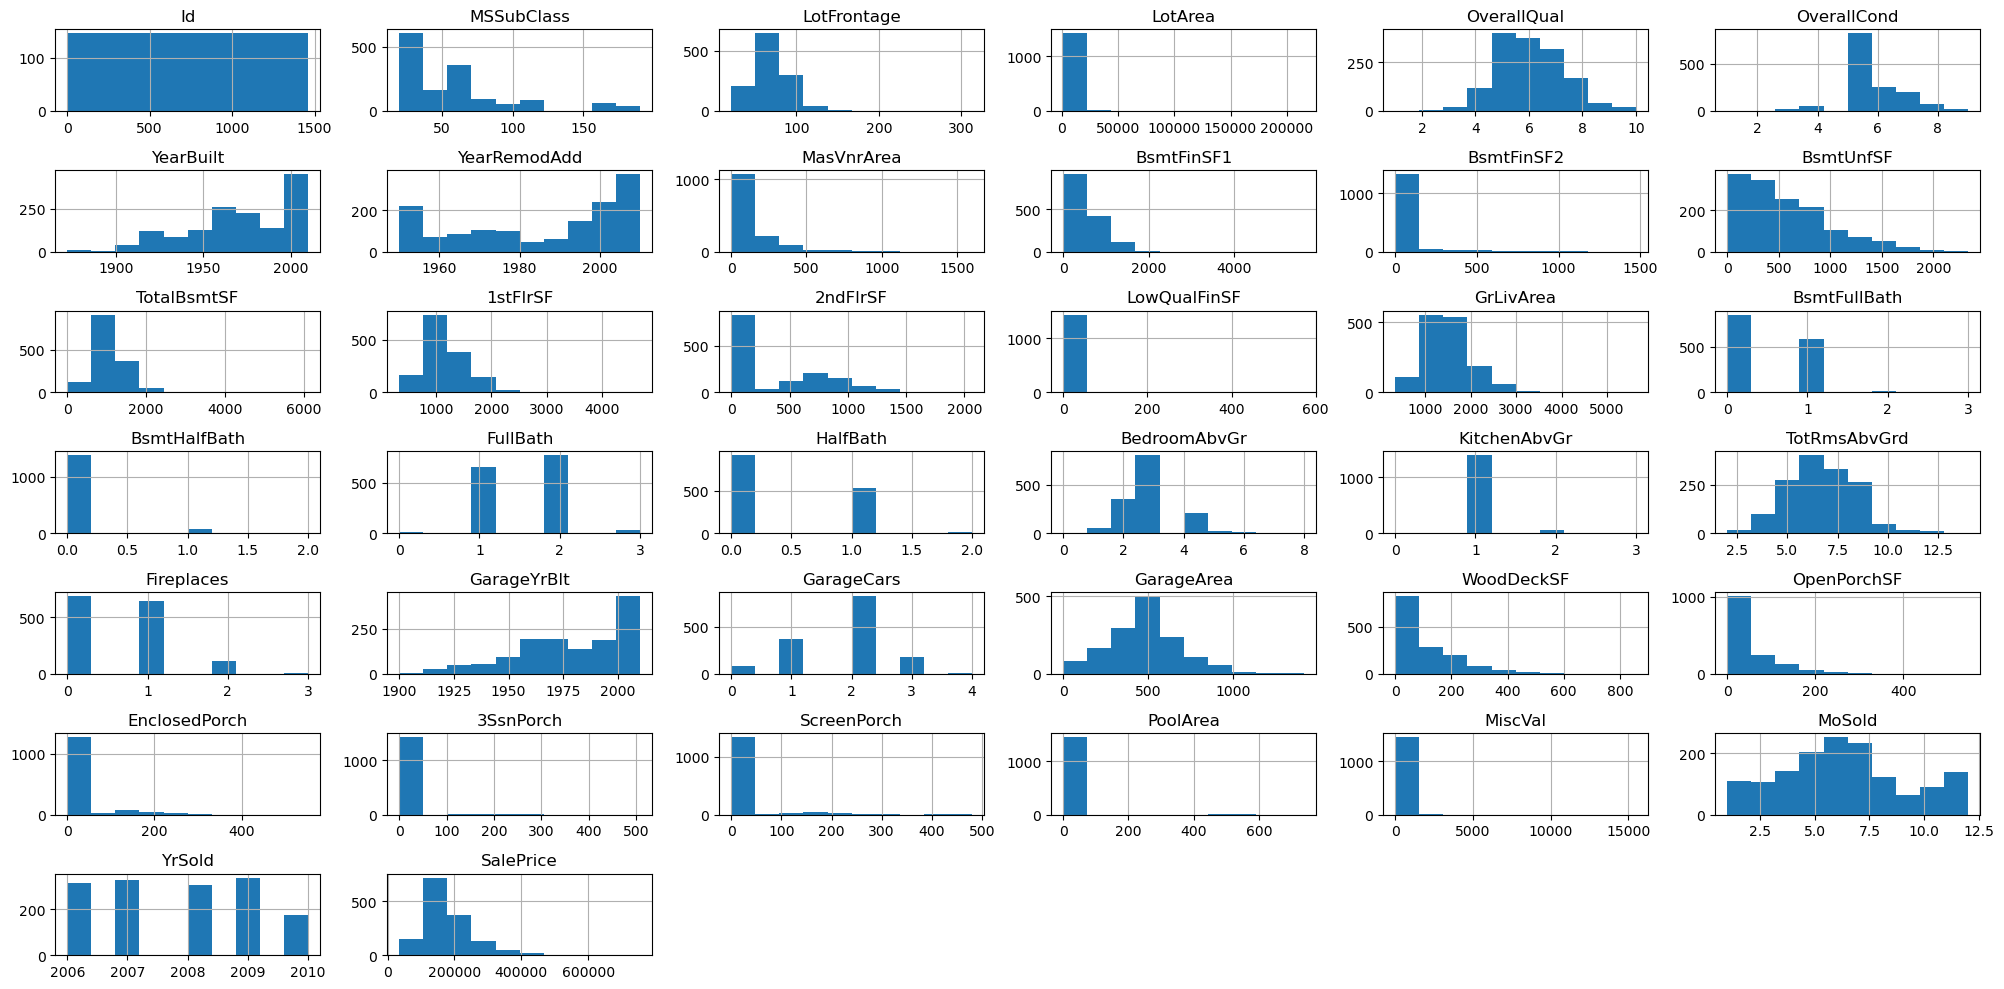

In [20]:
df.hist(figsize=(20, 10))
plt.tight_layout()

General Observations:
* Sales data is roughly between 2006 and 2010.
* More houses were sold in the summer months.
* Most houses are between 1000 - 2000 square feet.
* Most houses were built after 1950.

Take a look at the correlation of the numeric values vs. the sale price

In [21]:
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap="coolwarm", axis=None)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

General Observations:
* Sales Price looks to be correlated with:
    * OverallQual: Rates the overall material and finish of the house. Correlation is ~80% which seems significant.
    * GrLivArea: Above grade (ground) living area square feet.
    * Other features related to square feet like GarageCars, GarageArea, Total basement sq ft, etc...
 
The above correlations make a lot of sense.  It should be useful to create some latent features with PCA.  This will be explored more later.

Check for outlier sale price

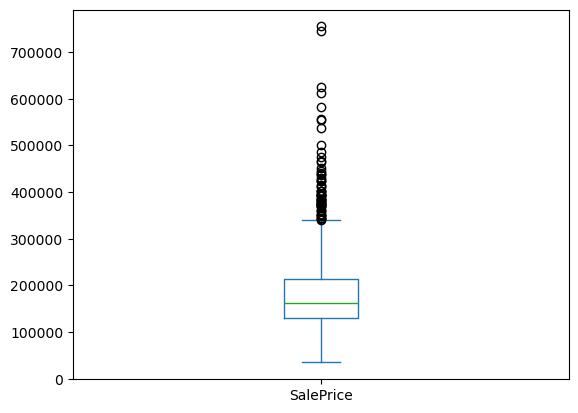

In [22]:
df.plot(y="SalePrice", kind="box");

There are two homes above 700K but that doesn't seem out of the norm for the housing market, so those will be left in.  This data distribution appears skewed.  It makes sense that the data would be lognormally distributed since negative home prices don't make sense.  Let's look at the original distribution and the log-transformed distribution.

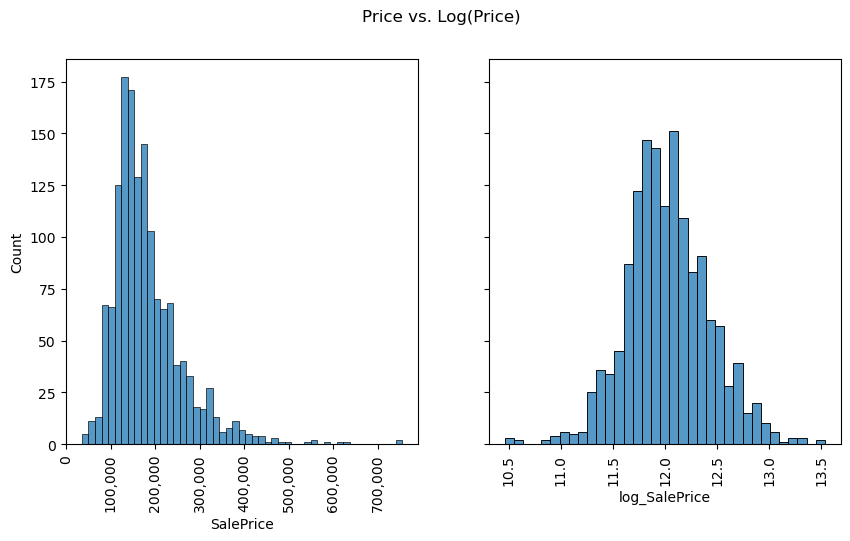

In [23]:
# first let's add the log sale price
df["log_SalePrice"] = df["SalePrice"].apply("log")

# graph both
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.histplot(df, x="SalePrice", ax=axs[0])
sns.histplot(df, x="log_SalePrice", ax=axs[1])
fig.suptitle("Price vs. Log(Price)")
axs[0].tick_params(axis="x", labelrotation=90)
axs[1].tick_params(axis="x", labelrotation=90)
formatter = ticker.StrMethodFormatter("{x:,.0f}")
axs[0].xaxis.set_major_formatter(formatter)

Due to the skewed SalePrice distribution the log of the sale price will be the feature used for predicting,

## Explore the categorical features

In [24]:
non_numeric_cols = df.select_dtypes(exclude="number").columns

In [25]:
# print some top info for each of the non-numeric columns
df_len = df.shape[0]
for col in df[non_numeric_cols]:
    names = list(df[col].value_counts().index)
    sliced_names = [str(name)[:25] for name in names]
    values = list(df[col].value_counts())
    print(f"{df[col].name}: {list(zip(sliced_names, values))}")

MSZoning: [('RL', 1151), ('RM', 218), ('FV', 65), ('RH', 16), ('C (all)', 10)]
Street: [('Pave', 1454), ('Grvl', 6)]
Alley: [('Grvl', 50), ('Pave', 41)]
LotShape: [('Reg', 925), ('IR1', 484), ('IR2', 41), ('IR3', 10)]
LandContour: [('Lvl', 1311), ('Bnk', 63), ('HLS', 50), ('Low', 36)]
Utilities: [('AllPub', 1459), ('NoSeWa', 1)]
LotConfig: [('Inside', 1052), ('Corner', 263), ('CulDSac', 94), ('FR2', 47), ('FR3', 4)]
LandSlope: [('Gtl', 1382), ('Mod', 65), ('Sev', 13)]
Neighborhood: [('NAmes', 225), ('CollgCr', 150), ('OldTown', 113), ('Edwards', 100), ('Somerst', 86), ('Gilbert', 79), ('NridgHt', 77), ('Sawyer', 74), ('NWAmes', 73), ('SawyerW', 59), ('BrkSide', 58), ('Crawfor', 51), ('Mitchel', 49), ('NoRidge', 41), ('Timber', 38), ('IDOTRR', 37), ('ClearCr', 28), ('StoneBr', 25), ('SWISU', 25), ('MeadowV', 17), ('Blmngtn', 17), ('BrDale', 16), ('Veenker', 11), ('NPkVill', 9), ('Blueste', 2)]
Condition1: [('Norm', 1260), ('Feedr', 81), ('Artery', 48), ('RRAn', 26), ('PosN', 19), ('RRAe

General Observations:
* It looks like some columns have high cardinality (Neighborhood, Exterior1st, Exterior2nd).
* Some features don't appear too informative (Street, Utilities) as almost 100% of the values are only in one category.
* It looks like for many of the features the categories are very skewed to the top value (where the second highest value in a column is almost a factor of 10 lower than the top value).
* Some non-numeric features appear ordinal (like BsmtQal and BsmtCond).  These could be re-encoded to numerical.

How many categories have more than 3 values (not including n/a).

In [26]:
greater = 0
total = 0
for col in df[non_numeric_cols]:
    num = df[col].value_counts().shape[0]
    if num > 3:
        greater += 1
    total += 1

print(
    f"{greater} non-numeric columns out of {total} have more than 3 categories.  This is a ratio of {greater/total:.2%}."
)

34 non-numeric columns out of 43 have more than 3 categories.  This is a ratio of 79.07%.


Due to the high number of columns with more than 3 categories, target encoding will be used for simplicity.  Target encoding uses the target mean conditioned on the categorical feature for encoding un-ordered categories.  This is useful for features with high cardinality.  See scikit-learn discussion <a href="https://scikit-learn.org/stable/modules/preprocessing.html#target-encoder">here.</a>



# Data Preparation

## Identify columns with missing data

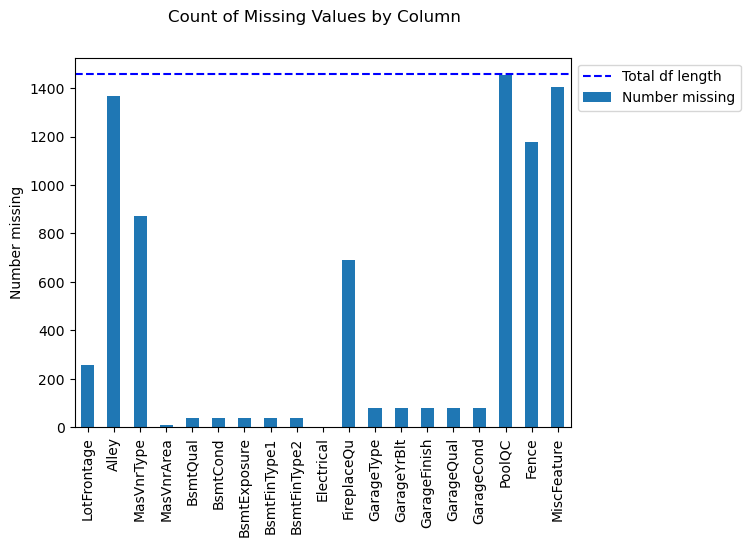

In [27]:
# identify and plot
missing_cols = df.columns[df.isna().any()].to_list()

fig, ax = plt.subplots()
df[missing_cols].isna().sum().plot.bar(ax=ax, label="Number missing")
ax.set_ylabel("Number missing")
fig.suptitle("Count of Missing Values by Column")
plt.axhline(y=df.shape[0], color="b", linestyle="--", label="Total df length")
ax.legend(bbox_to_anchor=(1, 1));

Based on the above it looks like dropping columns with more than 600 missing values might be a good thing to do.

However, when reading the data description, we see the following for PoolQC: NA = No Pool

So, in this case a value of NA is actually informative in that it means there is no pool.  This is different from a typical na value as typically na would mean we don't know anything about the pool value.  But in this case we know NA means there is no pool.  This information should be retained.

After reading through more descriptions we learn the same can be said of the following categories with > 600 missing values:
Alley, FireplaceQu, PoolQC, Fence, MiscFeature.

MasVnrType is a bit confusing as it uses the term None instead of NA.  Due to this confusion I am going to assume NA is truly missing to be safe.

Therefore the only column really worth dropping with >600 missing values is the MasVnrType field.

In [28]:
df.drop(columns=["MasVnrType"], inplace=True)

## Identify rows with missing values

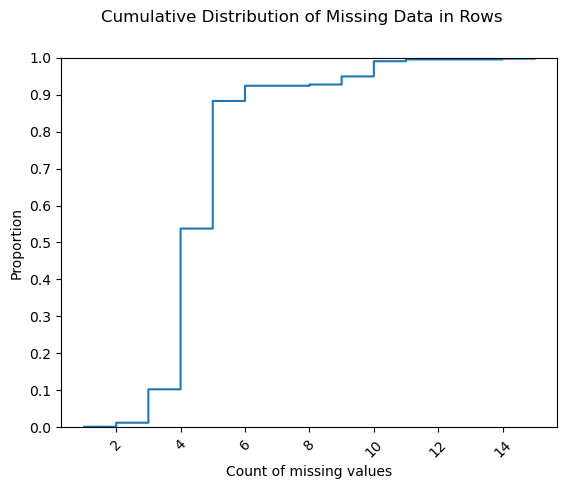

In [29]:
# identify and plot missing rows
missing_row = df.shape[1] - df.count(axis=1)  # number of missing values per row

fig, ax = plt.subplots()
sns.ecdfplot(missing_row, ax=ax)
plt.xticks(rotation=45)
ax.set_yticks(list(np.arange(0.0, 1.1, 0.1)))
plt.suptitle("Cumulative Distribution of Missing Data in Rows")
ax.set_xlabel("Count of missing values");

There are not many rows with lots of missing values.  Therefore these will be left as is and their values will be imputed during the modeling steps below.  The chart above shows that ~90% of rows are missing 5 or fewer values. We also know that alot of these "missing" values actually contain some useful info as noted above.

# Data Modeling

# Result Evaluation

# Deployment